In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading data

In [4]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [5]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


In [6]:
nclasses = len(labels_dict)
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [7]:
def generate_batch(batch_size=10):
    global train_X, train_y, labels_dict
    j = 0
    while 1:
        i = j
        if i+batch_size < len(train_X):
            j = i + batch_size
            raw_labels = train_y[i:i+batch_size]
            yield train_X[i:i+batch_size], raw_labels.flatten()
        else:
            j = 0
            raw_labels = np.concatenate((train_y[i:], train_y[0:batch_size-(len(train_y)-i)]))
            yield np.concatenate((train_X[i:], train_X[0:batch_size-(len(train_X)-i)])),\
                    raw_labels.flatten()
        

In [8]:
learning_rate = 0.05
batch_size = 1000
h_size = 128

In [9]:
graph = tf.Graph()
is_training = True
with graph.as_default():
    with tf.name_scope("inputs"):
        x = tf.placeholder(tf.float32, shape=[None, image_size, image_size])
        y = tf.placeholder(tf.int32, shape=[None])
        rnn_cell = tf.contrib.rnn.BasicRNNCell(h_size)
        if is_training:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, input_keep_prob=0.5)
        outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)
    
        logits = tf.contrib.layers.fully_connected(states, nclasses, activation_fn=None)
        
    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=y))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()

In [10]:
def run_session(graph, epochs, learning_rate, batch_size):
    start = time.time()
    accuracies = dict()
    losses = dict()
    batches = generate_batch(batch_size=batch_size)

    with tf.device("/gpu"), tf.Session(graph=graph) as sess:
        init.run()
        print("Variables initialized")
        average_loss = 0
        for e in range(epochs+1):
            batch_X, batch_y = batches.__next__()
            feed_dict = {x:batch_X, y:batch_y}
            is_training = True
            _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
            average_loss += np.mean(loss)
#                 if e%50 == 0:
            if e%10 == 0:
                print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss/10 if e>0 else average_loss))
            losses[e] = average_loss
            average_loss = 0
            is_training = False
            accuracy_ = sess.run([accuracy], feed_dict={x:test_X, y:test_y})
            accuracy_ = np.mean(accuracy_)
            accuracies[e] = accuracy_
            if e%10 == 0:
                print("Accuracy:{0}".format(accuracy_))
                print("~"*40)
    print("Took: {}".format(time.time()-start))

    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(accuracies.keys())
    data1 = [accuracies[i] for i in xticks]
    data2 = [losses[i] for i in xticks]

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(xticks, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Cross-entropy loss', color=color)
    ax2.plot(xticks, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [11]:
test_X = test_X.reshape(-1, image_size, image_size)
train_X = train_X.reshape(-1, image_size, image_size)
test_X.shape, train_X.shape

((18724, 28, 28), (529114, 28, 28))

Variables initialized
Epoch 0
Cross-entropy loss: 2.482369899749756
Accuracy:0.13624225556850433
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10
Cross-entropy loss: 0.19717143774032592
Accuracy:0.35142064094543457
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20
Cross-entropy loss: 0.17391976118087768
Accuracy:0.43596452474594116
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30
Cross-entropy loss: 0.16609611511230468
Accuracy:0.48381754755973816
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 40
Cross-entropy loss: 0.15564532279968263
Accuracy:0.5234992504119873
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50
Cross-entropy loss: 0.14904712438583373
Accuracy:0.5553834438323975
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 60
Cross-entropy loss: 0.14599021673202514
Accuracy:0.5895107984542847
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 70
Cross-entropy loss: 0.14069448709487914
Accuracy:0.6313287615776062
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 80
Cross-entropy loss: 0.13

Epoch 690
Cross-entropy loss: 0.0810640037059784
Accuracy:0.8513672351837158
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 700
Cross-entropy loss: 0.0797294020652771
Accuracy:0.849230945110321
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 710
Cross-entropy loss: 0.07915500402450562
Accuracy:0.8535035252571106
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 720
Cross-entropy loss: 0.07370848655700683
Accuracy:0.8572954535484314
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 730
Cross-entropy loss: 0.07639774084091186
Accuracy:0.8513672351837158
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 740
Cross-entropy loss: 0.07474128603935241
Accuracy:0.8574556708335876
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 750
Cross-entropy loss: 0.07974922060966491
Accuracy:0.8424481749534607
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 760
Cross-entropy loss: 0.07204574942588807
Accuracy:0.8576158881187439
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 770
Cross-entropy loss: 0.07993747591972351
A

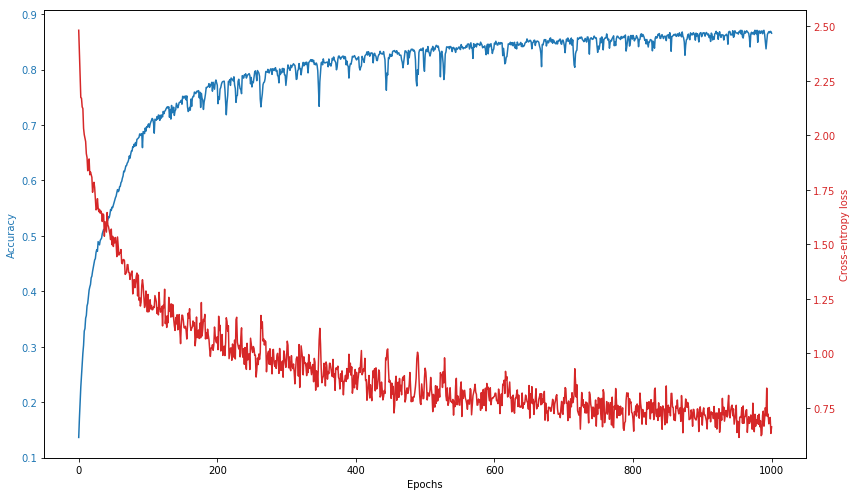

In [12]:
epochs = 1000
run_session(graph, epochs, learning_rate, batch_size)